### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [11]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [12]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
90,NSW91,1,31,11,1,0,1,1,0.0000,0.0000,14509.9300
570,PSID386,0,20,12,1,0,0,0,0.0000,0.0000,11594.2400
555,PSID371,0,26,14,0,0,0,0,0.0000,0.0000,6717.7450
593,PSID409,0,17,10,0,0,0,1,0.0000,0.0000,14942.7700
54,NSW55,1,30,11,1,0,1,1,0.0000,0.0000,590.7818
514,PSID330,0,22,16,1,0,0,0,2564.6800,0.0000,116.7404
35,NSW36,1,42,14,1,0,0,0,0.0000,0.0000,20505.9300
446,PSID262,0,20,8,0,0,1,1,621.0876,306.1452,5551.8190
139,NSW140,1,26,11,0,0,0,1,0.0000,2226.2660,13385.8600
381,PSID197,0,40,10,0,0,1,1,1543.9020,1342.7420,0.0000


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

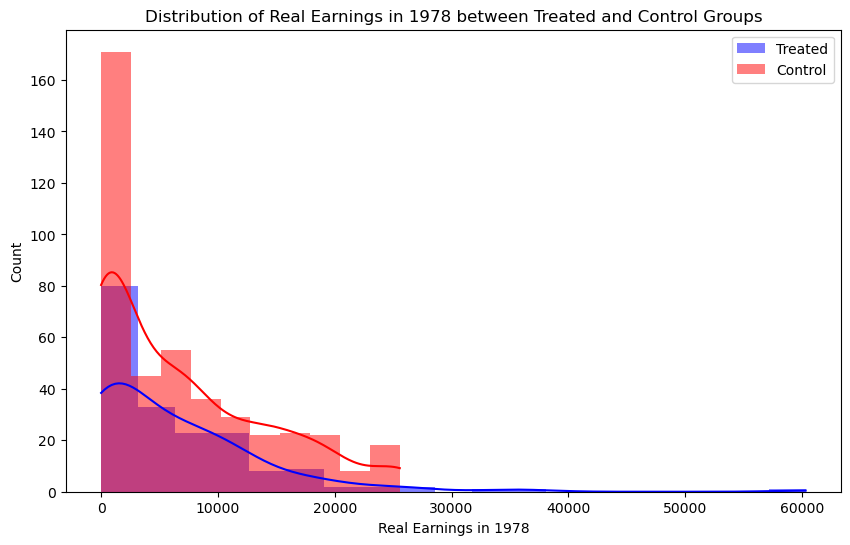

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64
count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64


In [16]:
''' your code and explanations ''';

treated = df[df['treat'] == 1]
control = df[df['treat'] == 0]
plt.figure(figsize=(10, 6))
sns.histplot(treated['re78'], color='blue', label='Treated', kde=True, stat="count", linewidth=0)
sns.histplot(control['re78'], color='red', label='Control', kde=True, stat="count", linewidth=0)
plt.legend()
plt.xlabel('Real Earnings in 1978')
plt.ylabel('Count')
plt.title('Distribution of Real Earnings in 1978 between Treated and Control Groups')
plt.show()


print(treated['re78'].describe())
print(control['re78'].describe())

We can see that the treated group has:
- lower mean income
-  higher first quartile but lower third quartile
- some outliers with really high income

We can see that the control group has:
- higher mean income
- lower first quartile but higher third quartile
- higher number of people in terms of income between 10000 and 20000

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

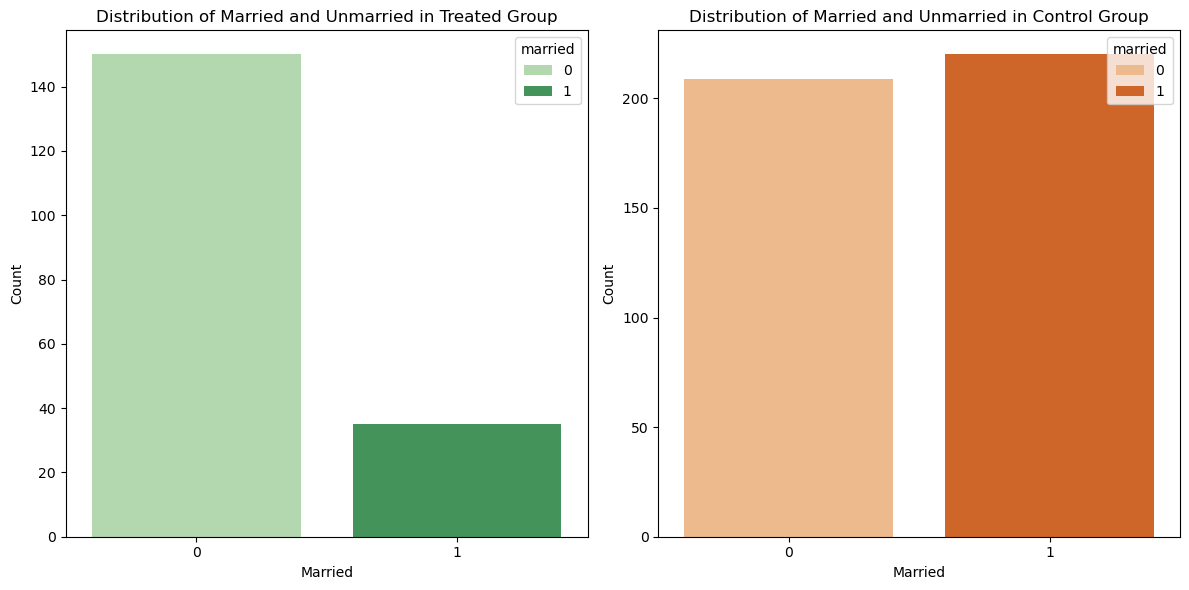

In [17]:
''' your code and explanations ''';

#Comparing the married treated and control groups
treated_married = treated.groupby('married').count()
control_married = control.groupby('married').count()

plt.figure(figsize=(12, 6))

# Plot for treated group
plt.subplot(1, 2, 1)
sns.barplot(x=treated_married.index, y=treated_married['id'], palette='Greens', hue=treated_married.index)
plt.title('Distribution of Married and Unmarried in Treated Group')
plt.xlabel('Married')
plt.ylabel('Count')

# Plot for control group
plt.subplot(1, 2, 2)
sns.barplot(x=control_married.index, y=control_married['id'], palette='Oranges', hue=control_married.index)
plt.title('Distribution of Married and Unmarried in Control Group')
plt.xlabel('Married')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Married and unmarried people are evened out in the the control group
# while the treated group has more unmarried people than married people 

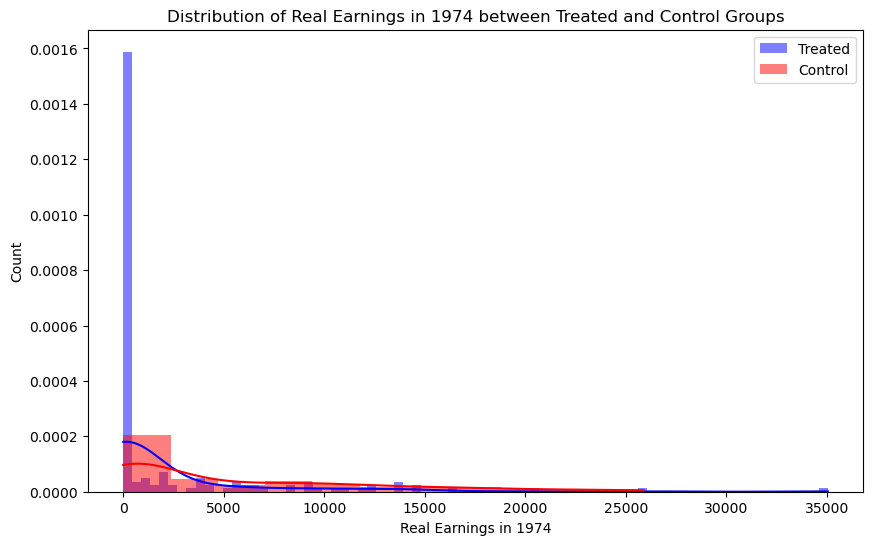

Description of treated Earnings in 1974
count      185.000000
mean      2095.573689
std       4886.620353
min          0.000000
25%          0.000000
50%          0.000000
75%       1291.468000
max      35040.070000
Name: re74, dtype: float64
Description of control Earnings in 1974
count      429.000000
mean      5619.236506
std       6788.750796
min          0.000000
25%          0.000000
50%       2547.047000
75%       9277.128000
max      25862.320000
Name: re74, dtype: float64


In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(treated['re74'], color='blue', label='Treated', kde=True, stat="density", linewidth=0)
sns.histplot(control['re74'], color='red', label='Control', kde=True, stat="density", linewidth=0)
plt.legend()
plt.xlabel('Real Earnings in 1974')
plt.ylabel('Count')
plt.title('Distribution of Real Earnings in 1974 between Treated and Control Groups')
plt.show()

print("Description of treated Earnings in 1974")
print(treated['re74'].describe())
print("Description of control Earnings in 1974")
print(control['re74'].describe())

#number of treated members that have no job was quite high 

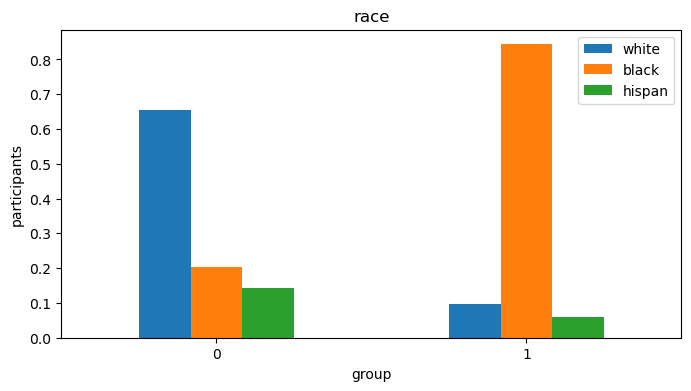

In [19]:
df['white'] = (~(df['black'].astype(bool) | df['hispan'].astype(bool))).astype(bool)

df_group = df.groupby(df.treat)[['white', 'black', 'hispan']].sum()
df_group = df_group.div(df_group.sum(axis=1), axis=0)
pl = df_group.plot(kind='bar', figsize=[8,4], rot=0)
pl.set_title('race')
pl.set_ylabel('participants')
pl.set_xlabel('group')
plt.show()

#White people are the majority in the control group while black are the majority in the treated group.


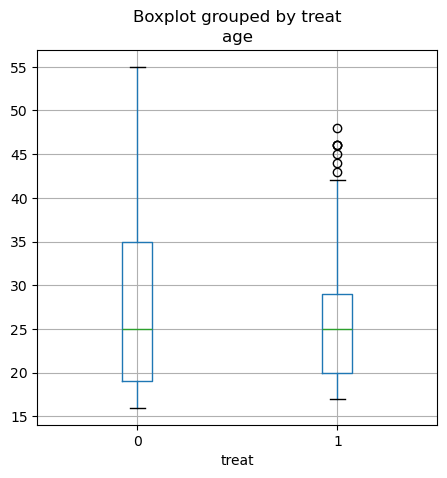

In [20]:
df.boxplot(column="age", by="treat", figsize=(5, 5))
plt.show()

#treated group is younger than the control group

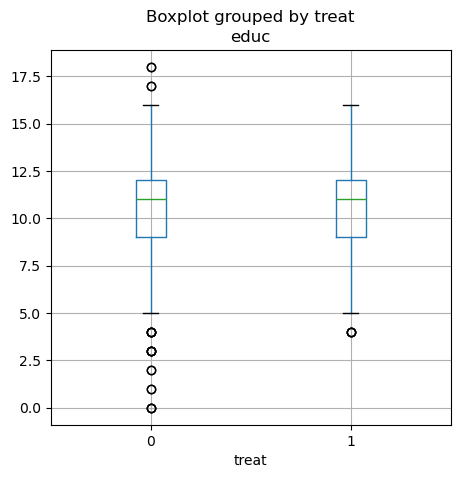

In [21]:
df.boxplot(column="educ", by="treat", figsize=(5, 5))
plt.show()

#Here it is a bit similar, wile there are more outliers in the contrl group

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [22]:
''' your code and explanations ''';
from statsmodels.stats import diagnostic
import statsmodels.api as sm
import statsmodels.formula.api as smf

#first we standardize the data
df["re74"] = (df["re74"] - df["re74"].mean()) / df["re74"].std()
df["re75"] = (df["re75"] - df["re75"].mean()) / df["re75"].std()
df["age"] = (df["age"] - df["age"].mean()) / df["age"].std()
df["educ"] = (df["educ"] - df["educ"].mean()) / df["educ"].std()

model = smf.logit('treat ~ age + educ + C(black) + C(hispan) + C(married) + C(nodegree) + re74 + re75', data=df)
result = model.fit()

df["propensity"] = result.predict()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Sat, 19 Oct 2024   Pseudo R-squ.:                  0.3508
Time:                        00:48:51   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [24]:
''' your code and explanations ''';
G = nx.Graph()

treated = df[df['treat'] == 1]
control = df[df['treat'] == 0]

for treat_id, rows_treat in treated.iterrows():
    for control_id, rows_control in control.iterrows():
        similarity = 1 - np.abs(rows_treat['propensity'] - rows_control['propensity'])

        G.add_weighted_edges_from([(control_id, treat_id, similarity)])

matching = nx.max_weight_matching(G) 




In [42]:
print(matching)
print(list(matching))
list_matching = []
for element in list(matching):
    list_matching.append(element[0])
    list_matching.append(element[1])
print(list_matching)

{(539, 61), (585, 3), (151, 409), (82, 456), (159, 215), (153, 345), (33, 557), (532, 30), (583, 78), (22, 355), (579, 65), (60, 540), (554, 63), (75, 364), (84, 525), (294, 14), (389, 32), (36, 393), (211, 126), (263, 118), (596, 44), (157, 466), (278, 109), (322, 88), (343, 10), (37, 611), (280, 155), (124, 261), (590, 158), (24, 595), (402, 77), (64, 283), (50, 513), (612, 173), (161, 545), (552, 12), (165, 442), (164, 507), (549, 178), (46, 564), (555, 139), (184, 376), (58, 492), (39, 268), (324, 160), (372, 121), (526, 5), (45, 464), (556, 122), (538, 116), (110, 593), (128, 608), (176, 386), (584, 92), (282, 74), (450, 131), (479, 167), (181, 354), (96, 295), (380, 8), (371, 94), (100, 201), (72, 575), (70, 383), (13, 535), (1, 542), (415, 20), (341, 135), (140, 392), (11, 452), (93, 588), (35, 510), (519, 150), (437, 163), (138, 477), (514, 26), (125, 422), (568, 180), (9, 293), (106, 387), (600, 4), (411, 98), (17, 370), (27, 609), (55, 451), (114, 348), (2, 424), (558, 105), 

In [43]:
matched_df = df.iloc[[element for element in list_matching]]

matched_df.head(20)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,propensity
539,PSID355,0,-0.846375,-0.482714,1,0,0,1,-0.644266,-0.662971,0.0000,False,0.683083
61,NSW62,1,0.165649,-0.863185,1,0,0,1,-0.703546,-0.662971,1923.9380,False,0.688262
585,PSID401,0,-1.048780,-0.102244,1,0,0,1,-0.703546,-0.662971,1053.6190,False,0.716120
3,NSW4,1,-0.036756,0.278227,1,0,0,1,-0.703546,-0.662971,7506.1460,False,0.776324
151,NSW152,1,-0.340363,0.658697,1,0,0,0,1.421466,0.199603,6167.6810,False,0.453863
409,PSID225,0,-0.947578,-0.863185,0,1,0,1,-0.703546,-0.389181,1306.3100,False,0.195439
82,NSW83,1,1.076471,0.658697,0,0,0,0,-0.703546,-0.662971,4941.8490,True,0.100341
456,PSID272,0,1.886090,-1.243655,0,0,0,1,-0.536593,-0.588548,0.0000,True,0.097003
159,NSW160,1,-0.643970,-0.863185,1,0,0,1,-0.550833,0.458467,4279.6130,False,0.688328
215,PSID31,0,-0.542768,1.039168,0,1,0,0,0.285166,1.728886,9453.0170,False,0.207618


## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [44]:
''' your code and explanations ''';
#By looking at the feature-value distributions, we cannot fully understand how the matching is done.
# We can see that even some of the similarity scores are really different for it to be a match.
# This shed light on the fact that there are features that are really weird. 

# Now we will filter the data to only keep the values with the ethnicity:

G = nx.Graph()
for treated_id, treated_rows in treated.iterrows():
    for control_id, control_rows in control.iterrows():

        if treated_rows['black'] == control_rows['black'] and treated_rows['hispan'] == control_rows['hispan']:

            similarity = 1 - np.abs(treated_rows['propensity'] - control_rows['propensity'])
            G.add_weighted_edges_from([(control_id, treated_id, similarity)])
    
matching = nx.max_weight_matching(G)


In [46]:
list_matching = []
for element in list(matching):
    list_matching.append(element[0])
    list_matching.append(element[1])

matched_df = df.iloc[[element for element in list_matching]]

matched_df.head(20)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,propensity
361,PSID177,0,-0.846375,0.278227,0,0,0,1,-0.703546,-0.149072,9853.481,True,0.135089
75,NSW76,1,-0.239161,0.278227,0,0,0,1,-0.703546,-0.662971,18783.350,True,0.135574
341,PSID157,0,-1.048780,-1.243655,1,0,0,1,-0.540827,0.030738,1613.677,False,0.619613
51,NSW52,1,0.368054,0.278227,1,0,1,1,-0.703546,-0.662971,8087.487,False,0.616653
302,PSID118,0,-0.745173,0.278227,1,0,0,1,-0.703546,0.393075,5495.665,False,0.789173
7,NSW8,1,0.469256,0.278227,1,0,0,1,-0.703546,-0.662971,8472.158,False,0.789723
459,PSID275,0,-0.441566,0.658697,0,1,1,0,-0.703546,-0.597239,0.000,False,0.093893
43,NSW44,1,-0.947578,-0.863185,0,1,1,1,-0.703546,-0.662971,2787.960,False,0.091505
559,PSID375,0,1.886090,0.278227,1,0,1,1,-0.703546,-0.662971,2820.980,False,0.670848
130,NSW131,1,-1.048780,-0.482714,1,0,0,1,-0.438569,-0.282643,5445.200,False,0.669909


## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

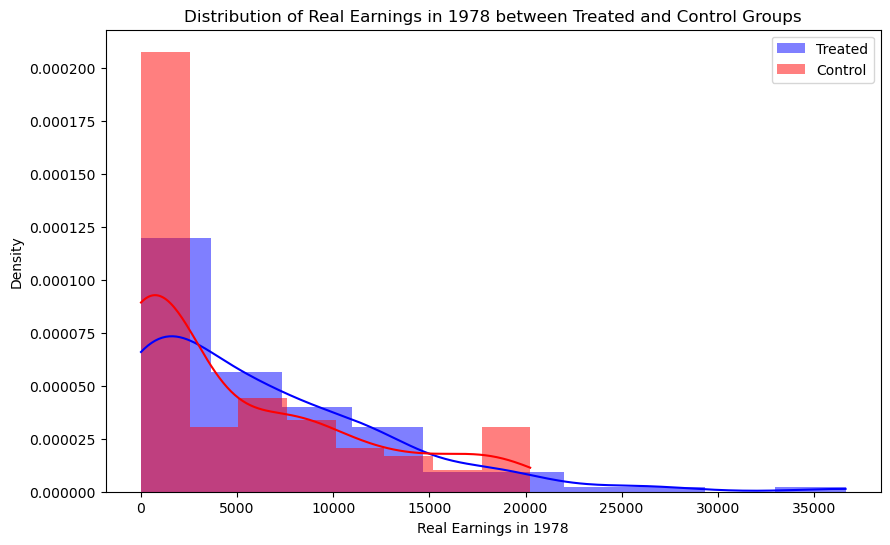

count      116.000000
mean      6166.431753
std       6655.656670
min          0.000000
25%        672.490925
50%       4300.659000
75%      10001.218250
max      36646.950000
Name: re78, dtype: float64
count      116.000000
mean      5095.456025
std       6047.014862
min          0.000000
25%          0.000000
50%       2256.488500
75%       8942.092750
max      20243.380000
Name: re78, dtype: float64


In [49]:
''' your code and explanations ''';
treated = matched_df[matched_df['treat'] == 1]
control = matched_df[matched_df['treat'] == 0]

plt.figure(figsize=(10, 6))
sns.histplot(treated['re78'], color='blue', label='Treated', kde=True, stat="density", linewidth=0)
sns.histplot(control['re78'], color='red', label='Control', kde=True, stat="density", linewidth=0)
plt.legend()
plt.xlabel('Real Earnings in 1978')
plt.ylabel('Density')
plt.title('Distribution of Real Earnings in 1978 between Treated and Control Groups')
plt.show()


print(treated['re78'].describe())
print(control['re78'].describe())

# Positive effect of the treatment on the earnings of the treated group